# First level analysis with Nipype + SPM

## Download all necessary packages

In [83]:
from nipype.interfaces import spm
from nilearn.plotting import plot_anat, plot_img, plot_stat_map
from nilearn.image import index_img
from nipype import Workflow
import pandas as pd
import os

## Get paths to our functional image and to our events file

In [84]:
functional_img = '/data/single_files/auditory_fmri_img.nii'
events_file = '/data/single_files/auditory_events.tsv'

## Plot the first 3D image of the time series

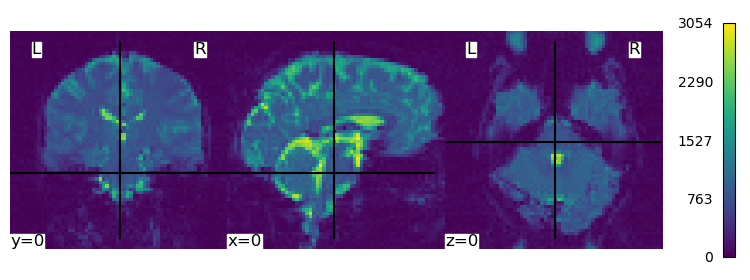

In [85]:
first_volume = index_img(functional_img,0)
plot_img(first_volume, cut_coords=(0,0,0),colorbar=True, cbar_tick_format="%i")

## Let's plot the events file so we know what's going on

In [86]:
events = pd.read_table(events_file)
events

,onset,duration,trial_type,amplitude
0,0.0,42.0,rest,1
1,42.0,42.0,active,1
2,84.0,42.0,rest,1
3,126.0,42.0,active,1
4,168.0,42.0,rest,1
5,210.0,42.0,active,1
6,252.0,42.0,rest,1
7,294.0,42.0,active,1
8,336.0,42.0,rest,1
9,378.0,42.0,active,1


## Use Nipype & SPM to conduct a first level analysis

In [87]:
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype import Workflow, Node

## Specify everything that SPM needs

In [88]:
model_specifier = Node(SpecifySPMModel(concatenate_runs=False,
                                       input_units='secs',
                                       output_units='secs',
                                       time_repetition=7,
                                       high_pass_filter_cutoff=128,
                                       functional_runs = ['/data/single_files/auditory_fmri_img.nii'],
                                       bids_event_file = ['/data/single_files/auditory_events.tsv']
                                      ),
                       name='model_specifier')

# Level1Design - Generates an SPM design matrix
first_level_design = Node(Level1Design(bases={'hrf':{'derivs': [0,0]}},
                                       interscan_interval=7,
                                       timing_units='secs',
                                       model_serial_correlations='FAST'),
                          name='first_level_design')

# EstimateModel - estimate the parameters of the model
first_level_estimator = Node(EstimateModel(estimation_method={'Classical': 1}),name='first_level_estimator')

## EstimateContrast - estimate contrasts
contrast_1 = ('Active > Rest','T', ['active','rest'],[1,-1])
contrast_2 = ('Rest > Active','T', ['active','rest'],[-1,1])
first_level_contrasts = Node(EstimateContrast(), name='first_level_contrasts')
first_level_contrasts.inputs.contrasts = [contrast_1,contrast_2]

## Connect all nodes to a Workflow

In [ ]:
# define workflow
wf = Workflow(name='first_level_analysis',base_dir='/cache')
wf.connect(model_specifier,'session_info',first_level_design,'session_info')
wf.connect(first_level_design,'spm_mat_file',first_level_estimator,'spm_mat_file')
wf.connect(first_level_estimator,'spm_mat_file',first_level_contrasts,'spm_mat_file')
wf.connect(first_level_estimator,'beta_images',first_level_contrasts,'beta_images')
wf.connect(first_level_estimator,'residual_image',first_level_contrasts,'residual_image')
wf.run()

## Plot the workflow

231128-16:50:40,6 nipype.workflow INFO:
	 Generated workflow graph: /cache/first_level_analysis/graph.png (graph2use=hierarchical, simple_form=True).


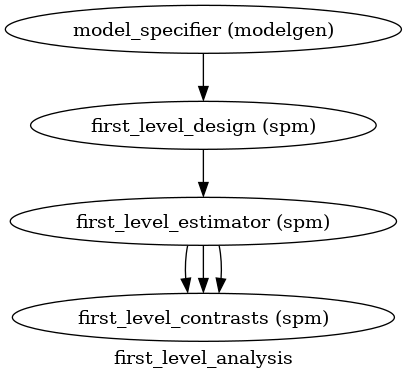

In [90]:
# Create 1st-level analysis output graph
wf.write_graph()
from IPython.display import Image
Image(filename='/cache/first_level_analysis/graph.png')

# Plot the statistical image

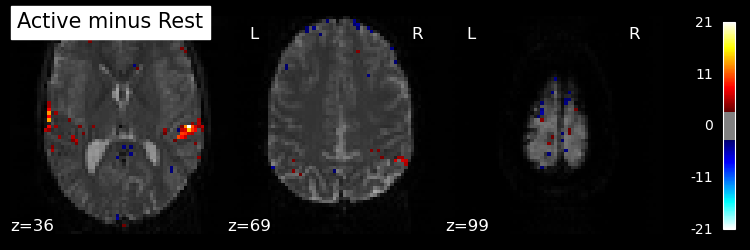

In [91]:
# Plot the image
from nilearn.image import load_img
from nilearn.image import mean_img
from nilearn.plotting import plot_stat_map

# create a background image using the average of our functional image
mean_img = mean_img(functional_img)

# load the contrast image
contrast_img = load_img('/cache/first_level_analysis/first_level_contrasts/spmT_0001.nii')

# plot contrast on top functional image
plot_stat_map(stat_map_img=contrast_img,
              bg_img=mean_img,
              threshold=3.0,
              display_mode="z",
              cut_coords=3,
              black_bg=True,
              title="Active minus Rest",
)

## The 'first_level_analysis' folder looks nasty. Can't we make it more pretty?

In [ ]:
# Yes we can! By defining a DataSink node where files should be stored
datasink = Node(DataSink(base_directory='/output'),name="datasink")
wf.connect(first_level_contrasts,'spmT_images',datasink,'spm_contrast_images')
wf.run()

# I always can't remember what the numbers in T_xxxx stand for...

In [ ]:
# let's remove the last datasink node, redefine it and reconnect it again
wf.remove_nodes([datasink])
datasink = Node(DataSink(base_directory='/output',
                         substitutions=[('spmT_0001.nii','active_greater_rest.nii'),
                                        ('spmT_0002.nii','rest_greater_active.nii')]),
                name="datasink")
wf.connect(first_level_contrasts,'spmT_images',datasink,'spm_contrast_images')
wf.run()